In [1]:
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import itertools

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
NUM_WORKERS = 2
EPOCHS_SIMPLE = 5
EPOCHS_HEAD = 5          # adapter head training epochs
LR = 1e-3
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)


# count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Prepare MNIST datasets
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
transform_test = transform_train

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# For pretrained models we need 3 channels and 224x224
transform_pretrained = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Lambda(lambda img: img.convert("RGB")),  # convert 1ch to 3ch PIL image
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
])
# Datasets/loaders for pretrained backbones (train and test) to train adapter heads and run inference
train_dataset_pre = datasets.MNIST(root="./data", train=True, download=True, transform=transform_pretrained)
test_dataset_pre = datasets.MNIST(root="./data", train=False, download=True, transform=transform_pretrained)
train_loader_pre = DataLoader(train_dataset_pre, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader_pre = DataLoader(test_dataset_pre, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 517kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.41MB/s]


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # why: small model for MNIST baseline
        self.conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # preserves spatial dims
        self.pool = nn.MaxPool2d(2,2)
        # after conv+pool: 28x28 -> 14x14 with 32 channels
        self.flatten_dim = 32 * 14 * 14
        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.conv(x))
        x = self.pool(x)
        x = x.view(-1, self.flatten_dim)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def evaluate_model(model, loader, device=DEVICE, return_preds=False):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            preds.append(predicted.cpu().numpy())
            trues.append(labels.numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro')
    return acc, f1, (trues, preds)

def train_model(model, train_loader, test_loader, epochs=5, lr=1e-3, device=DEVICE):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for imgs, labels in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{epochs}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)

        # evaluate
        acc, _, _ = evaluate_model(model, test_loader, device=device)
        if acc > best_acc:
            best_acc = acc
            best_model = copy.deepcopy(model.state_dict())
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Test Acc: {acc:.4f}")
    model.load_state_dict(best_model)
    return model

# Train SimpleCNN
simple_model = SimpleCNN()
print("SimpleCNN parameters (trainable):", count_parameters(simple_model))
simple_trained = train_model(simple_model, train_loader, test_loader, epochs=EPOCHS_SIMPLE, lr=LR, device=DEVICE)


def make_backbone_with_head(backbone_name="alexnet", pretrained=True, device=DEVICE):
    # returns model, input_size, feature_dim
    if backbone_name == "alexnet":
        backbone = models.alexnet(pretrained=pretrained)
        # AlexNet features end with classifier[6] mapping to 1000. We'll use features + avgpool flatten
        # Get feature dim: alexnet.classifier[1] input dim is 256*6*6 = 9216 typically
        # We will replace classifier with identity to extract features.
        feature_extractor = backbone.features
        # create a wrapper that reproduces the forward to flattened features
        class AlexNetBackbone(nn.Module):
            def __init__(self, features):
                super().__init__()
                self.features = features
                self.avgpool = backbone.avgpool
            def forward(self, x):
                x = self.features(x)
                x = self.avgpool(x)
                x = torch.flatten(x, 1)
                return x
        feat_ex = AlexNetBackbone(feature_extractor)
        feature_dim = 256 * 6 * 6  # alexnet feature map flattened
        input_size = (3,224,224)
        return feat_ex.to(device), feature_dim, input_size

    elif backbone_name == "mobilenet_v2":
        m = models.mobilenet_v2(pretrained=pretrained)
        # mobilenet_v2.features gives features, classifier is [1] with last linear.
        class MobileNetV2Backbone(nn.Module):
            def __init__(self, model):
                super().__init__()
                self.features = model.features
                self.pool = nn.AdaptiveAvgPool2d((1,1))
            def forward(self, x):
                x = self.features(x)
                x = self.pool(x)
                x = torch.flatten(x,1)
                return x
        feat_ex = MobileNetV2Backbone(m)
        # feature dim equals last channel size (1280 for default mobilenet_v2)
        feature_dim = 1280
        input_size = (3,224,224)
        return feat_ex.to(device), feature_dim, input_size
    else:
        raise ValueError("Unsupported backbone")

# function to train only the small head attached to frozen backbone
def train_head(backbone, feature_dim, train_loader_pre, test_loader_pre, epochs=3, lr=1e-3, device=DEVICE):
    # freeze backbone
    backbone.eval()
    for p in backbone.parameters():
        p.requires_grad = False
    # small head
    head = nn.Linear(feature_dim, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(head.parameters(), lr=lr)
    best_head = copy.deepcopy(head.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        head.train()
        running_loss = 0.0
        for imgs, labels in tqdm(train_loader_pre, desc=f"Head Train Epoch {epoch+1}/{epochs}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.no_grad():
                feats = backbone(imgs)
            preds = head(feats)
            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        epoch_loss = running_loss / len(train_loader_pre.dataset)
        # evaluate
        acc, f1, _ = evaluate_backbone_with_head(backbone, head, test_loader_pre, device=device)
        if acc > best_acc:
            best_acc = acc
            best_head = copy.deepcopy(head.state_dict())
        print(f"Head Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Test Acc: {acc:.4f}")
    head.load_state_dict(best_head)
    # return a combined model wrapper for evaluation convenience
    class BackboneWithHead(nn.Module):
        def __init__(self, backbone, head):
            super().__init__()
            self.backbone = backbone
            self.head = head
        def forward(self, x):
            feats = self.backbone(x)
            return self.head(feats)
    combined = BackboneWithHead(backbone, head).to(device)
    return combined

def evaluate_backbone_with_head(backbone, head, loader, device=DEVICE):
    model = nn.Sequential(backbone, head).to(device)
    return evaluate_model(model, loader, device=device)

# Create + train AlexNet head
alex_backbone, alex_feat_dim, _ = make_backbone_with_head("alexnet", pretrained=True, device=DEVICE)
print("AlexNet backbone feature dim:", alex_feat_dim, "params (backbone):", count_parameters(alex_backbone))
alexnet_with_head = train_head(alex_backbone, alex_feat_dim, train_loader_pre, test_loader_pre, epochs=EPOCHS_HEAD, lr=LR, device=DEVICE)

# Create + train MobileNetV2 head
mobilenet_backbone, mobilenet_feat_dim, _ = make_backbone_with_head("mobilenet_v2", pretrained=True, device=DEVICE)
print("MobileNetV2 backbone feature dim:", mobilenet_feat_dim, "params (backbone):", count_parameters(mobilenet_backbone))
mobilenet_with_head = train_head(mobilenet_backbone, mobilenet_feat_dim, train_loader_pre, test_loader_pre, epochs=EPOCHS_HEAD, lr=LR, device=DEVICE)

SimpleCNN parameters (trainable): 804554


Epoch 1/5 - Loss: 0.2015 - Test Acc: 0.9746


Epoch 2/5 - Loss: 0.0677 - Test Acc: 0.9827


Epoch 3/5 - Loss: 0.0465 - Test Acc: 0.9850


Epoch 4/5 - Loss: 0.0317 - Test Acc: 0.9845


Epoch 5/5 - Loss: 0.0242 - Test Acc: 0.9843


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 185MB/s]


AlexNet backbone feature dim: 9216 params (backbone): 2469696


Head Epoch 1/5 - Loss: 0.0738 - Test Acc: 0.9893


Head Epoch 2/5 - Loss: 0.0218 - Test Acc: 0.9865


Head Epoch 3/5 - Loss: 0.0137 - Test Acc: 0.9913


Head Epoch 4/5 - Loss: 0.0101 - Test Acc: 0.9888


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Head Epoch 5/5 - Loss: 0.0097 - Test Acc: 0.9903
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 154MB/s]


MobileNetV2 backbone feature dim: 1280 params (backbone): 2223872


Head Epoch 1/5 - Loss: 0.4468 - Test Acc: 0.9486


Head Epoch 2/5 - Loss: 0.1733 - Test Acc: 0.9566


Head Epoch 3/5 - Loss: 0.1328 - Test Acc: 0.9651


Head Epoch 4/5 - Loss: 0.1126 - Test Acc: 0.9649


Head Epoch 5/5 - Loss: 0.0995 - Test Acc: 0.9708


In [4]:
def inference_time_and_metrics(model, loader, device=DEVICE):
    model = model.to(device)
    model.eval()

    preds = []
    trues = []
    t0 = time.perf_counter()
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            preds.append(predicted.cpu().numpy())
            trues.append(labels.numpy())
    t1 = time.perf_counter()
    total_time = t1 - t0
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro')
    cm = confusion_matrix(trues, preds)
    return dict(accuracy=acc, f1=f1, confmat=cm, time=total_time)

# Evaluate SimpleCNN on original 1x28x28 test loader
print(" SimpleCNN on MNIST test set (1x28x28)")
simple_metrics = inference_time_and_metrics(simple_trained, test_loader, device=DEVICE)

# Evaluate pretrained+head models on resized 3x224x224 test loader
print(" AlexNet+head on MNIST test set (resized 3x224x224)")
alex_metrics = inference_time_and_metrics(alexnet_with_head, test_loader_pre, device=DEVICE)

print(" MobileNetV2+head on MNIST test set (resized 3x224x224)")
mobilenet_metrics = inference_time_and_metrics(mobilenet_with_head, test_loader_pre, device=DEVICE)


 SimpleCNN on MNIST test set (1x28x28)
 AlexNet+head on MNIST test set (resized 3x224x224)
 MobileNetV2+head on MNIST test set (resized 3x224x224)


In [5]:
# Parameter counts (trainable total) — for pretrained combos count all params (backbone frozen but still exists; show total and trainable)
def total_and_trainable_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

simple_total, simple_trainable = total_and_trainable_params(simple_trained)
alex_total, alex_trainable = total_and_trainable_params(alexnet_with_head)
mobilenet_total, mobilenet_trainable = total_and_trainable_params(mobilenet_with_head)


In [9]:
def print_results(name, metrics, total_params, trainable_params):
    print(f"\n--- {name} ---")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 (macro): {metrics['f1']:.4f}")
    print(f"Inference time on test set: {metrics['time']:.4f} seconds")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    #print("Confusion matrix:\n", metrics['confmat'])

print_results("SimpleCNN", simple_metrics, simple_total, simple_trainable)
print_results("AlexNet + head", alex_metrics, alex_total, alex_trainable)
print_results("MobileNetV2 + head", mobilenet_metrics, mobilenet_total, mobilenet_trainable)


--- SimpleCNN ---
Accuracy: 0.9850
F1 (macro): 0.9849
Inference time on test set: 1.7250 seconds
Total parameters: 804,554
Trainable parameters: 804,554

--- AlexNet + head ---
Accuracy: 0.9913
F1 (macro): 0.9912
Inference time on test set: 19.7685 seconds
Total parameters: 2,561,866
Trainable parameters: 92,170

--- MobileNetV2 + head ---
Accuracy: 0.9708
F1 (macro): 0.9704
Inference time on test set: 16.8967 seconds
Total parameters: 2,236,682
Trainable parameters: 12,810


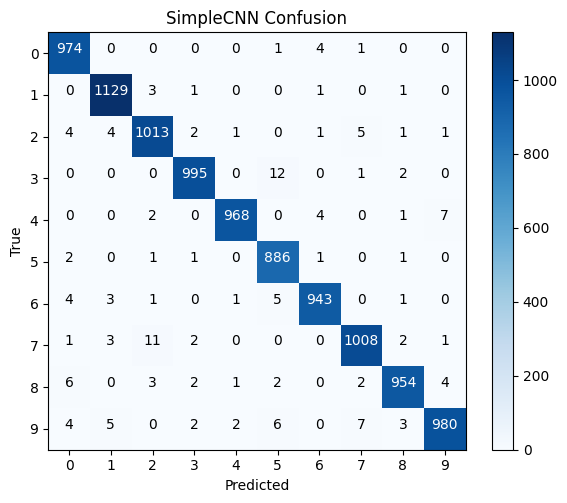

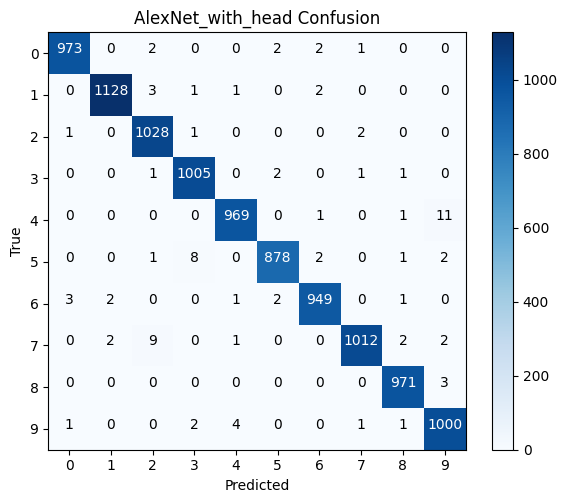

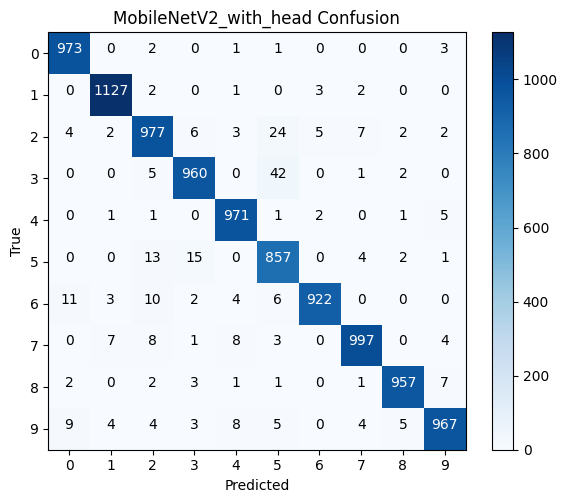

In [12]:
def plot_confusion(cm, title):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(10)
    plt.xticks(ticks)
    plt.yticks(ticks)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()

plot_confusion(simple_metrics['confmat'], "SimpleCNN Confusion")
plot_confusion(alex_metrics['confmat'], "AlexNet_with_head Confusion")
plot_confusion(mobilenet_metrics['confmat'], "MobileNetV2_with_head Confusion")